# **A Transformer Model for Language Translation**

In [31]:
!pip install -U torchdata==0.5.1
!pip install -U spacy==3.7.2
!pip install -Uqq portalocker==2.7.0
!pip install torchtext==0.17.2
!pip install torchdata==0.7.1
!pip install -Uq nltk==3.8.1
!pip install torchtext==0.17.2

!python -m spacy download de
!python -m spacy download en

!pip install pdfplumber==0.9.0
!pip install fpdf==1.7.2

!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py'
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/transformer.pt'
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/input_de.pdf'

In [1]:
from torchtext.datasets import multi30k, Multi30k
import torch
from typing import Iterable, List
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
from tqdm import tqdm

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

## 1. DataLoader

In [3]:
%run Multi30K_de_en_dataloader.py

In [4]:
train_dataloader, _ = get_translation_dataloaders(batch_size = 1)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Masking

In [5]:
def generate_square_subsequent_mask(sz,device=DEVICE):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt,device=DEVICE):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## 3. Positional encoding

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

## 4. Token embedding

In [7]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

## 5. Transformer architecture for language translation

In [8]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()

        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        outs =outs.to(DEVICE)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

## 6. Inference

In [9]:
torch.manual_seed(0)

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

In [10]:
transformer.load_state_dict(torch.load('transformer.pt', map_location=DEVICE, ))

<All keys matched successfully>

In [11]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

In [12]:
data_itr=iter(train_dataloader)
for n in range(100):
    src ,tgt= next(data_itr)

num_tokens = src.shape[0]
src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE )
print(index_to_german(src))
max_len=src.shape[0]+5

ys=greedy_decode(transformer, src, src_mask, max_len, start_symbol=BOS_IDX)
print("engish ",index_to_eng(ys))

print("engish ",index_to_eng(tgt))

<bos> Drei Männer sitzen lachend . <eos>
engish  <bos> Three men are sitting down laughing . <eos>
engish  <bos> Three men are sitting down laughing . <eos>


### Training

In [13]:
def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0

    # Wrap train_dataloader with tqdm for progress logging
    train_iterator = tqdm(train_dataloader, desc="Training", leave=False)

    for src, tgt in train_iterator:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask = src_mask.to(DEVICE)
        tgt_mask = tgt_mask.to(DEVICE)
        src_padding_mask = src_padding_mask.to(DEVICE)
        tgt_padding_mask = tgt_padding_mask.to(DEVICE)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = logits.to(DEVICE)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        # Update tqdm progress bar with the current loss
        train_iterator.set_postfix(loss=loss.item())

    return losses / len(list(train_dataloader))

### Evaluate

In [14]:
def evaluate(model):
    model.eval()
    losses = 0



    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [15]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

In [18]:
from torch.nn import CrossEntropyLoss
from timeit import default_timer as timer

train_dataloader, val_dataloader = get_translation_dataloaders(batch_size = BATCH_SIZE)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer = transformer.to(DEVICE)

loss_fn = CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

TrainLoss=[]
ValLoss=[]
NUM_EPOCHS = 20
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, train_dataloader)
    TrainLoss.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    ValLoss.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
torch.save(transformer.state_dict(), 'transformer_de_to_en_model.pt')

Epoch: 1, Train loss: 5.093, Val loss: 4.392, Epoch time = 35.251s


Epoch: 2, Train loss: 3.885, Val loss: 3.857, Epoch time = 35.855s


Epoch: 3, Train loss: 3.491, Val loss: 3.598, Epoch time = 35.509s


Epoch: 4, Train loss: 3.232, Val loss: 3.393, Epoch time = 35.818s


Epoch: 5, Train loss: 3.036, Val loss: 3.265, Epoch time = 35.253s


Epoch: 6, Train loss: 2.878, Val loss: 3.134, Epoch time = 36.718s


Epoch: 7, Train loss: 2.739, Val loss: 3.021, Epoch time = 35.634s


Epoch: 8, Train loss: 2.622, Val loss: 2.933, Epoch time = 35.426s


Epoch: 9, Train loss: 2.516, Val loss: 2.861, Epoch time = 35.085s


Epoch: 10, Train loss: 2.421, Val loss: 2.807, Epoch time = 34.969s


Epoch: 11, Train loss: 2.333, Val loss: 2.752, Epoch time = 35.004s


Epoch: 12, Train loss: 2.252, Val loss: 2.703, Epoch time = 35.024s


Epoch: 13, Train loss: 2.174, Val loss: 2.673, Epoch time = 34.806s


Epoch: 14, Train loss: 2.106, Val loss: 2.629, Epoch time = 34.817s


Epoch: 15, Train loss: 2.037, Val loss: 2.590, Epoch time = 34.777s


Epoch: 16, Train loss: 1.972, Val loss: 2.558, Epoch time = 34.693s


Epoch: 17, Train loss: 1.910, Val loss: 2.525, Epoch time = 35.088s


Epoch: 18, Train loss: 1.853, Val loss: 2.505, Epoch time = 35.342s


Epoch: 19, Train loss: 1.795, Val loss: 2.473, Epoch time = 35.262s


Epoch: 20, Train loss: 1.741, Val loss: 2.466, Epoch time = 35.223s


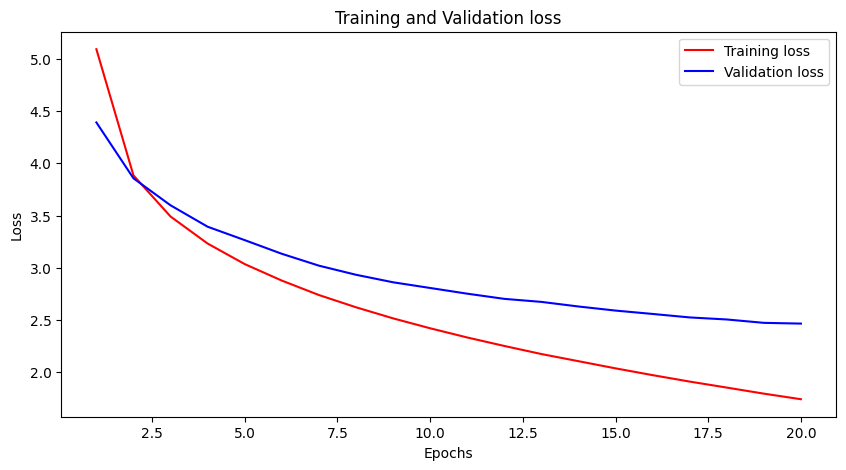

In [19]:
epochs = range(1, len(TrainLoss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, TrainLoss, 'r', label='Training loss')
plt.plot(epochs,ValLoss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Loading the saved model

In [23]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/transformer_de_to_en_model.pt'
transformer1 = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer1 = transformer1.to(DEVICE)
transformer1.load_state_dict(torch.load('transformer_de_to_en_model.pt',map_location=torch.device('cpu')))

--2025-07-13 16:35:19--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/transformer_de_to_en_model.pt
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144561810 (138M) [binary/octet-stream]
Saving to: ‘transformer_de_to_en_model.pt.2’

transformer_de_to_e 100%[===================>] 137.86M  36.5MB/s    in 3.6s    

2025-07-13 16:35:23 (38.8 MB/s) - ‘transformer_de_to_en_model.pt.2’ saved [144561810/144561810]



<All keys matched successfully>

### Translation and evaluation

In [20]:
# translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [24]:
for n in range(5):
    german, english= next(data_itr)

    print("German Sentence:",index_to_german(german).replace("<bos>", "").replace("<eos>", ""))
    print("English Translation:",index_to_eng(english).replace("<bos>", "").replace("<eos>", ""))
    print("Model (20 epochs) Translation:",translate(transformer,index_to_german(german)))
    print("Model (300 epochs) Translation:",translate(transformer1,index_to_german(german)))

    print("_________\n")

German Sentence:  Zwei Personen beim Kehren . 
English Translation:  Two people sweeping a dirt ground . 
Model (20 epochs) Translation:  Two people are walking around a street , with some kind of some people are using a
Model (300 epochs) Translation:  Two people are walking around a street , with some kind of some people are using a
_________

German Sentence:  Arbeiter verlegen neue Wasserrohre . 
English Translation:  Worker 's installing new water pipes . 
Model (20 epochs) Translation:  Workers are gathered around a silver street full of snow covered in black and white robes .
Model (300 epochs) Translation:  Workers are gathered around a silver street full of snow covered in black and white robes .
_________

German Sentence:  Straßenmusiker spielen vor Bänken . 
English Translation:  Street musicians perform in front of benches . 
Model (20 epochs) Translation:  A street performer is playing an open violin in front of a white - war . 
Model (300 epochs) Translation:  A street p

#### Evaluate with BLEU Score

In [25]:
def calculate_bleu_score(generated_translation, reference_translations):
    # convert the generated translations and reference translations into the expected format for sentence_bleu
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # calculate the BLEU score
    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

In [26]:
generated_translation = translate(transformer,"Ein brauner Hund spielt im Schnee .")

reference_translations = ["A brown dog is playing in the snow .", "A brown dog plays in the snow .",
                          "A brown dog is frolicking in the snow .", "In the snow, a brown dog is playing ."]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score, "for",generated_translation)

BLEU Score: 0.3867706276352344 for  A brown dog playing in the snow with snow in the snow .


## Translating a document

In [28]:
import pdfplumber
import textwrap
from fpdf import FPDF

def translate_pdf(input_file, translator_model,output_file):
    translated_text=""
    with pdfplumber.open(input_file) as pdf:
        for page in pdf.pages:
            text_content = page.extract_text()
            num_pages=len(pdf.pages)
            a4_width_mm = 210
            pt_to_mm = 0.35
            fontsize_pt = 10
            fontsize_mm = fontsize_pt * pt_to_mm
            margin_bottom_mm = 10
            character_width_mm = 7 * pt_to_mm
            width_text = a4_width_mm / character_width_mm

            pdf = FPDF(orientation='P', unit='mm', format='A4')
            pdf.set_auto_page_break(True, margin=margin_bottom_mm)
            pdf.add_page()
            pdf.set_font(family='Courier', size=fontsize_pt)
            # Split the text into sentences
            sentences = text_content.split(".")

            for sentence in sentences:
                translated_sentence = translate(translator_model,sentence)
                lines = textwrap.wrap(translated_sentence, width_text)
                if len(lines) == 0:
                    pdf.ln()
                for wrap in lines:
                    pdf.cell(0, fontsize_mm, wrap, ln=1)
            pdf.output(output_file, 'F')

In [29]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/input_de.pdf'

--2025-07-13 16:37:30--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/input_de.pdf
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27628 (27K) [application/pdf]
Saving to: ‘input_de.pdf.1’

input_de.pdf.1      100%[===================>]  26.98K  --.-KB/s    in 0.03s   

2025-07-13 16:37:31 (856 KB/s) - ‘input_de.pdf.1’ saved [27628/27628]



In [30]:
input_file_path = 'input_de.pdf'
output_file = 'output_en.pdf'
# Call the translate_pdf() defined earlier for the input file
translate_pdf(input_file_path, transformer, output_file)
print("Translated PDF file is saved as:", output_file)

Translated PDF file is saved as: output_en.pdf
